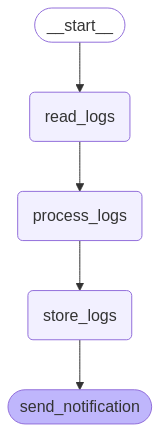

All lambda functions are ==> ['test1', 'test2']
processed_logs start 
{'test1': 'The given CloudWatch log shows a list of errors that occurred in the Lambda function named "test1". The errors are categorized as Critical, Warning, and Info.\n\nCritical errors are the most severe type of errors and indicate a critical situation that requires immediate attention. In the given log, there is one critical error that occurs in the Lambda function named "test1" at the line number 15. The error message is "Value exceeds threshold! Immediate attention required!".\n\nWarning errors are less severe than critical errors but still indicate a potential issue that should be addressed. In the given log, there are two warning', 'test2': 'The given logs have the following errors:\n\n1. ERROR: Value cannot be zero! - Critical Error\n2. END RequestId: 1558ff97-15b6-4267-bbd1-4913028d186c - Info'}
processed_logs end 
SNS Message ID: c08e7ef2-5835-57cc-8b8e-1ea334ffb205


{'lambda_functions': ['test1', 'test2'],
 'logs': {'test1': 'INIT_START Runtime Version: python:3.13.v31\tRuntime Version ARN: arn:aws:lambda:us-east-1::runtime:f713ac0afb982fcdf9bac88eaa00c31352efae870b225c19f1603fe79159a6f1\n\nSTART RequestId: 15154523-1458-413a-82bf-ad40b7312e93 Version: $LATEST\n\n[INFO]\t2025-03-15T02:46:28.693Z\t15154523-1458-413a-82bf-ad40b7312e93\tINFO: Lambda function started successfully.\n\n[ERROR]\t2025-03-15T02:46:28.694Z\t15154523-1458-413a-82bf-ad40b7312e93\tERROR: ERROR: Value cannot be zero!\n\nEND RequestId: 15154523-1458-413a-82bf-ad40b7312e93\n\nREPORT RequestId: 15154523-1458-413a-82bf-ad40b7312e93\tDuration: 18.72 ms\tBilled Duration: 19 ms\tMemory Size: 128 MB\tMax Memory Used: 31 MB\tInit Duration: 124.42 ms\t\n\nSTART RequestId: 2d46027b-23ae-47af-b71a-ad8b29647349 Version: $LATEST\n\n[INFO]\t2025-03-15T02:46:46.660Z\t2d46027b-23ae-47af-b71a-ad8b29647349\tINFO: Lambda function started successfully.\n\n[WARNING]\t2025-03-15T02:46:46.660Z\t2d4602

In [20]:
from langgraph.graph import StateGraph
from dataclasses import dataclass
from langchain_community.llms import Bedrock
import boto3
import json
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["AWS_ACCESS_KEY_ID"]=os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"]=os.getenv("AWS_SECRET_ACCESS_KEY")
os.environ["AWS_REGION"]=os.getenv("AWS_REGION")


# Function to create a session
def create_aws_session():
    return boto3.Session(
        aws_access_key_id=os.environ["AWS_ACCESS_KEY_ID"],
        aws_secret_access_key=os.environ["AWS_SECRET_ACCESS_KEY"],
        region_name=os.environ["AWS_REGION"]
    )

# Initialize AWS Session
session = create_aws_session()

# Create AWS Clients using the session
sns_client = session.client("sns")
s3_client = session.client("s3")
logs_client = session.client("logs")
lambda_client = session.client("lambda")
bedrock_client = session.client("bedrock-runtime")

# Amazon Titan Model
llm = Bedrock(
    model_id="amazon.titan-text-express-v1",
    client=bedrock_client
)


@dataclass
class WorkflowState:
    lambda_functions: list
    #log_group_name: str = "/aws/lambda/test1"
    logs: str = ""
    processed_logs: dict = None  # Change from str to dict for structured logs
    s3_links: dict = None  # Store S3 links for each Lambda function

    def __post_init__(self):
        if self.logs is None:
            self.logs = {}
        if self.processed_logs is None:
            self.processed_logs = {}
        if self.s3_links is None:
            self.s3_links = {}


# Step 1: Find Lambda Functions by Prefix
def find_lambda_functions_by_prefix(prefix="test1"):
    functions = []
    paginator = lambda_client.get_paginator("list_functions")
    for page in paginator.paginate():
        for function in page.get("Functions", []):
            function_name = function["FunctionName"]
            if function_name.startswith(prefix):
                functions.append(function_name)
    return functions

# Step 2: Read CloudWatch Logs for Each Lambda Function
def read_cloudwatch_logs(state):
    logs_dict = {}
    for function_name in state.lambda_functions:
        log_group_name = f"/aws/lambda/{function_name}"
        try:
            response = logs_client.describe_log_streams(logGroupName=log_group_name)
            log_streams = response.get("logStreams", [])
            
            if log_streams:
                log_stream_name = log_streams[-1]["logStreamName"]
                log_events = logs_client.get_log_events(
                    logGroupName=log_group_name,
                    logStreamName=log_stream_name
                )
                logs = "\n".join([event["message"] for event in log_events["events"]])
            else:
                logs = "No logs found."

            logs_dict[function_name] = logs
        except Exception as e:
            logs_dict[function_name] = f"Error retrieving logs: {str(e)}"
    
    state.logs = logs_dict
    return state


# Step 3: Process Logs with LLM
def process_logs(state):
    processed_logs = {}
    for function_name, logs in state.logs.items():
        prompt = f"""Analyze the following CloudWatch logs and categorize errors as Critical, Warning, or Info. 
        Provide a summary of the errors found for function {function_name}. Logs:
        {logs}"""

        response = llm.generate([prompt])
        processed_logs[function_name] = response.generations[0][0].text  # Extract first response
    
    state.processed_logs = processed_logs

    print("processed_logs start ")
    print(processed_logs)
    print("processed_logs end ")
    
    return state

# Step 4: Store Logs in S3
def store_logs_in_s3(state):
    bucket_name = "testbucket-cw-logstore"
    s3_links = {}

    for function_name, processed_log in state.processed_logs.items():
        file_name = f"processed_logs_{function_name}.json"
        s3_client.put_object(
            Bucket=bucket_name, 
            Key=file_name, 
            Body=json.dumps({"logs": processed_log})
        )
        s3_links[function_name] = f"https://s3.amazonaws.com/{bucket_name}/{file_name}"
    
    state.s3_links = s3_links
    return state

#Step 5- sns notification
def send_sns_notification(state):
    warning_logs = []
    critical_logs = []

    # Categorizing logs
    for function_name, processed_log in state.processed_logs.items():
        if "WARNING" in processed_log:
            warning_logs.append((function_name, processed_log))
        if "CRITICAL" in processed_log:
            critical_logs.append((function_name, processed_log))

    # Table
    message = "### CloudWatch Error Summary \n\n"
    message += "| Severity  | Lambda Function  | Log Details  |\n"
    message += "|-----------|-----------------|--------------|\n"

    for function_name, log_details in warning_logs:
        message += f"| WARNING   | {function_name} | {log_details} |\n"

    for function_name, log_details in critical_logs:
        message += f"| CRITICAL  | {function_name} | {log_details} |\n"

    message += "\n### 🔍 Full logs stored in S3:\n"
    
    # Add S3 Links for reference
    for function_name, link in state.s3_links.items():
        message += f"- [{function_name}]({link})\n"

    # Send Email via SNS
    response = sns_client.publish(
        TopicArn="arn:aws:sns:us-east-1:050451365316:testsnstopic",
        Message=message,
        Subject="AWS Lambda Warning & Critical Logs",
        MessageStructure="string"
    )

    print("SNS Message ID:", response["MessageId"])
    return state


# Define Graph Workflow
graph = StateGraph(WorkflowState)
graph.add_node("read_logs", read_cloudwatch_logs)
graph.add_node("process_logs", process_logs)
graph.add_node("store_logs", store_logs_in_s3)
graph.add_node("send_notification", send_sns_notification)

graph.add_edge("read_logs", "process_logs")
graph.add_edge("process_logs", "store_logs")
graph.add_edge("store_logs", "send_notification")

graph.set_entry_point("read_logs")
workflow = graph.compile()

# Find Lambda functions and run the workflow

from IPython.display import Image, display
display(Image(workflow.get_graph().draw_mermaid_png()))

lambda_functions = find_lambda_functions_by_prefix("test")
print(f"All lambda functions are ==> {lambda_functions}")
workflow.invoke(
    WorkflowState(
        lambda_functions=lambda_functions,
        logs={},
        processed_logs={},
        s3_links={}
    )
)



